In [1]:
# Pkg.add("Images")  (Type this once, if you never used any version of Images)
# Pkg.update()       (Type this once if you used an earlier broken Images)

using Images         # This is needed every time the kernel is started or reloaded

## Inspired  from the last assignment in <a href="http://cs.brown.edu/courses/cs019/2014/assignments.html"> Brown cs019 </a> illustrating compressing an image width.  <br>

This notebook is organized into eight  parts <br>
1. Get images <br>
2. Brightness <br>
3. Energy <br>
4. Least Energy <br>
5. Get and Display Seam <br>
6. Carve Seam <br>
7. Examples <br>
8. Opportunities to Extend <br>

### 1.  Get images (may take 30 secondsish)

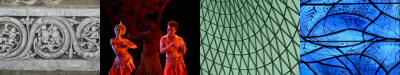

In [2]:
filenames = ["belur-carving", "bangalore-dancers", "british-museum","mainz-chagall-fenster"];


# wget images from Brown if not present
for file in filenames
  if ~isfile("$file-s2.jpg")
    run(`wget http://cs.brown.edu/courses/cs019/2014/Assignments/Fluid-Images/$file-s2.jpg`);
  end
end
ims = vcat([imread("$file-s2.jpg") for file in filenames]...)

# Belur     Bangalore    British     Chagall


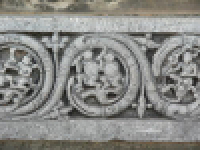

In [3]:
imread("belur-carving-s2.jpg")

INFO: Recompiling stale cache file /Users/alanedelman/.julia/lib/v0.4/Reactive.ji for module Reactive.


Interact.Slider{Int64}([Reactive.Input{Int64}] 2,"i",2,1:4)

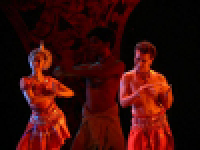

In [4]:
# Let's show off manipulate just because everyone likes it!
using Interact
@manipulate for i in 1:4
    imread("$(filenames[i])-s2.jpg")
end

In [5]:
# let's see the size of the image
img = imread("bangalore-dancers-s2.jpg")
size(img)

(100,75)

<h3> Note on Image Coordinates </h3>
Image coordinates  (x,y)
follow the horizontal major convention of screen coordinates (column, row)
measured from the top left to the bottom right.
This is annoyingly different from matrix conventions which use (row,column)
and Cartesian coordinates which has y going from bottom to top.

See <a href="https://github.com/timholy/Images.jl#storage-order-and-changing-the-representation-of-images"> Julia's image doc </a> for an excellent
discussion.  For example if you just can't handle it or are interfacing with MATLAB
you can type <br> <tt> img_array = convert(ARRAY,img)  </tt>  which effectively takes a transpose.

### 2. BRIGHTNESS

In [6]:
# brightness of a color is the sum of the r,g,b values (stored as float32's)
brightness(c)        =  c.r + c.g + c.b

# brightness of an image bordered with zeros
function brightness(I::Image)
  w, h = size(I)
  b = [brightness(I[x,y]) for x=1:w, y=1:h]
  # borders
  zv = fill(0f0,1,  h)  #  vertical zero 
  zh = fill(0f0,w+2,1)  #  horizontal zero 
  [zh  [zv; b; zv]  zh] 
 end

brightness (generic function with 2 methods)

### 3. ENERGY

In [7]:
# the 3x3 stencil for energy
function stencil(b)
      xenergy = b[1,1]+2b[2,1]+b[3,1]-b[1,3]-2b[2,3]-b[3,3]
      yenergy = b[1,1]+2b[1,2]+b[1,3]-b[3,1]-2b[3,2]-b[3,3]
      √(xenergy^2 + yenergy^2)
end
    
# energy of an array of brightness values 
# input: assumed zero borders
# output: left and right set to ∞
function energy(b)
  w, h = size(b)
  e = [float32(stencil( b[x-1:x+1, y-1:y+1] )) for x=2:w-1,y=2:h-1]
  infcol = fill(Inf32,1,h-2)
  [infcol; e; infcol]
end

energy (generic function with 1 method)

### 4. LEAST ENERGY FROM BOTTOM TO TOP

In [8]:
#  e (row                  e[x,y] 
#  dirs:                ↙   ↓   ↘       <--directions naturally live between the rows
#  e (row y+1): e[x-1,y+1] e[x,y+1]  e[x+1,y+1]     
# Basic Comp:   e[x,y] += min( e[x-1,y+1],e[x,y],e[x+1,y])
#               dirs records which one from (1==SW,2==S,3==SE)


# Take an array of energies and work up from bottom to top accumulating least energy to bottom
function least_energy(e)
   # initialize dirs 
   w, h = size(e)
   dirs = fill(0, w-2, h-1) # w-2 because we don't need the infs, h-1 because arrows between rows
   # compute
   for y=h-1:-1:1, x=2:w-1          
        s, dirs[x-1,y] = findmin(e[x+[-1, 0, 1], y+1]) # findmin gets the min and the index
        e[x,y] += s   #  add in current energy +  smallest from below
   end
   e[2:w-1,1], dirs  # return top row without infinities and dirs
end

least_energy (generic function with 1 method)

### 5. GET and DISPLAY  SEAM FUNCTIONS

In [9]:
function get_seam(dirs,x)
  seam = fill(0,1+size(dirs,2))
  seam[1]=x
  for y=1:size(dirs,2)
    seam[y+1] = seam[y] + dirs[seam[y],y] - 2
  end
  seam
end

using Colors
#Mark a seam
function mark_seam(img, seam, color=RGB4{U8}(1,1,1))
    img2 = copy(img)
    for y=1:length(seam)
        img2[seam[y], y]=color
    end
    img2
end

# Everyone just loves this !!!
function manipulate_seam(url::String)
  fn = split(url,"\/")[end]
  if ~isfile(fn)
   run(`wget $url`)
  end
  img = imread(fn)
  _,dirs  = least_energy(energy(brightness(img)))
  @manipulate for x=1:size(img,1)
    mark_seam(img, get_seam(dirs,x))
  end
end


manipulate_seam (generic function with 1 method)

In [10]:
println(imread("Wfm_stata_center.jpg")[1,1])

RGB4{U8}(

In [11]:
RGB4{U8}(0.494,0.62,0.78)

In [12]:
convert(RGB4{U8}, RGB(1,1,1))

0.494,0.62,0.78)


In [ ]:
# put your favorite image url here
# manipulate_seam("http://www.prasannaholidays.com/wp-content/uploads/2015/03/charminar_hyderabad-400x300.jpg")
# Stata  size=(664,593)
 manipulate_seam("http://upload.wikimedia.org/wikipedia/commons/2/25/Wfm_stata_center.jpg")
# Yosemite size=(4288,2848)
 # manipulate_seam("http://upload.wikimedia.org/wikipedia/commons/e/ec/1_yosemite_valley_tunnel_view_2010.JPG")

## 6. CARVE SEAM

In [ ]:
function minseam(img)
  e, dirs = least_energy(energy(brightness(img)))
  x = indmin(e)
  seam = get_seam(dirs,x)
end
    
    
function carve(img,seam)
  w, h = size(img)
  newimg = copy(img)
  newimg.data  = newimg[1:w-1,:]         # one pixel less wide
  for y=1:h
    s=seam[y]
    newimg[:,y] = img[[1:s-1,s+1:end],y] # delete pixel x=s on row y
  end
  newimg
 end
    
carve(img) = carve(img, minseam(img))  

function carve(img, n::Int)
  img2 = copy(img)
  for i=1:n
    img2 = carve(img2)
  end
  img2
end

## 7. Examples

In [ ]:
# This is a utility function (you do not need to understand it) 
# which overrides Ijulia's image widget so that manipulate displays with the proper width
immutable ImgFrame
    img::Image
end
Base.writemime(io::IO, m::MIME"text/html", frame::ImgFrame) = 
write(io, """<img src="data:image/png;base64,$(stringmime(MIME("image/png"), frame.img))"/>""")

In [ ]:
# The (100x75) examples in the pset are so small, and julia is so fast,
# we can manipulate these in real time
@manipulate for fn=filenames, x=1:100
    img = imread("$fn-s2.jpg")
    ImgFrame(carve(img,x))
end

In [ ]:
# Stata takes a while to compute, it's worth precomputing and
# then displaying.  Note quantities are being recomputed each time
# unnecessarily when they could be reused.
# One can imagine a lower complexity computation.


if ~isfile("Wfm_stata_center.jpg")
  run(`wget http://upload.wikimedia.org/wikipedia/commons/2/25/Wfm_stata_center.jpg`)
end
img = imread("Wfm_stata_center.jpg")


#Charminar
#=
if ~isfile("2.jpg")
  run(`wget http://www.prasannaholidays.com/wp-content/uploads/2015/03/charminar_hyderabad-400x300.jpg`)
end
img = imread("charminar_hyderabad-400x300.jpg")
=#
#Singapore
#=
if ~isfile("2.jpg")
    run(`wget http://media-cdn.tripadvisor.com/media/photo-s/01/5d/02/31/merlion-statue-at-merlion.jpg`)
end
img = imread("merlion-statue-at-merlion.jpg")
=#
println("When we reach $(size(img,1)-1) we have carved the image down to 1 pixel wide:")
A=[img for i=1:1] # set up a vector of images
for i=1:size(img,1)-1
    push!(A,carve(A[end]))
    if(rem(i,5)==0) || i==size(img,1)-1 print(i, " ") end
end


In [ ]:
size(img)

In [ ]:
@manipulate for image_width=slider(20:size(img,1), value=size(img,1))
    ImgFrame(A[1+size(img,1)-image_width])
end

### 8. Opportunities to Extend 

a. explore other energy functions <br>
b. explore lower complexity algorithms <br>
c. explore parallel computation 